In [1]:
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
month = 1
num_mon = '%02d' % month
AVDlabel = pd.read_csv('/home/fuhy/data/CALIPSO/CALIPSO_AVD_2016_' + num_mon + '.csv', header=[0])

In [3]:
def getMODdoy(dt):
    date = np.floor(dt)
    time = dt - date
    t = datetime.datetime.strptime('20' + str(date)[0:6], '%Y%m%d') + timedelta(days=time)
    doy = (t - datetime.datetime(t.year, 1, 1)).days//8*8 + 1
    return doy

In [4]:
dt = AVDlabel['Profile_UTC_Time_2']
doy = dt.apply(getMODdoy)
doy

0          1
1          1
2          1
3          1
4          1
          ..
697083    25
697084    25
697085    25
697086    25
697087    25
Name: Profile_UTC_Time_2, Length: 697088, dtype: int64

In [8]:
def getMODlat(lat):
    # 根据经纬度找到对应MOD11网格点
    # From top to bottom:    90 : 0.05 : -89.95
    # From left to right:  -180 : 0.05 : 179.95 
    idx_lat = round((90-lat)/0.05)
    return idx_lat


def getMODlon(lon):
    # 根据经纬度找到对应MOD11网格点
    # From top to bottom:    90 : 0.05 : -89.95
    # From left to right:  -180 : 0.05 : 179.95
    idx_lon = round((lon+180)/0.05)
    return idx_lon

In [6]:
lat = AVDlabel['Latitude_2']
lon = AVDlabel['Longitude_2']
print(lon.min(),lon.max(),lat.max(),lat.min())

-180.0 179.9999 60.01987 -60.01947


In [9]:
idx_lat = lat.apply(getMODlat)
idx_lon = lon.apply(getMODlon)
idx_lon[idx_lon == 7200] = 0
print(idx_lon.min(),idx_lon.max(),idx_lat.max(),idx_lat.min())

0 7199 3000 600


In [15]:
doy = 1
doystr = '%03d' % doy
MOD11all = np.load('MOD11C2.A2016'+doystr+'.061.itp.npy')

In [16]:
print(doystr)
data.shape

001


(3600, 7200, 6)

In [23]:
bands = ['Emis_20', 'Emis_22', 'Emis_23', 'Emis_29', 'Emis_31', 'Emis_32']
df = pd.DataFrame(columns=['MOD11_'+s for s in bands])
df.loc[0] = data[2,2,:]
df

,MOD11_Emis_20,MOD11_Emis_22,MOD11_Emis_23,MOD11_Emis_29,MOD11_Emis_31,MOD11_Emis_32
0,0.99,0.99,0.99,0.99,0.99,0.99


In [12]:
doy.unique()

array([ 1,  9, 17, 25])

In [3]:
list(range(1, 366, 8))

[1,
 9,
 17,
 25,
 33,
 41,
 49,
 57,
 65,
 73,
 81,
 89,
 97,
 105,
 113,
 121,
 129,
 137,
 145,
 153,
 161,
 169,
 177,
 185,
 193,
 201,
 209,
 217,
 225,
 233,
 241,
 249,
 257,
 265,
 273,
 281,
 289,
 297,
 305,
 313,
 321,
 329,
 337,
 345,
 353,
 361]

In [2]:
# File path
C2path = '/home/public/data/MODIS/MOD11C2/v061/'
C3path = '/home/public/data/MODIS/MOD11C3/'
# Getting the filename list:
import os
C2list=[filename for filename in
    os.listdir(C2path)
    if filename.endswith('.hdf')]
# listC2 = list(reversed(listC2))
C3list=[filename for filename in
    os.listdir(C3path)
    if filename.endswith('.hdf')]
# listC3 = list(reversed(listC3))
# SD_file = SD(C2path+C2list[0])
# ds_dict = SD_file.datasets()
# print(ds_dict)

In [3]:
def getC3month(C2name):
    dtstr = C2name[9:16]  # year and DoY
    dt = datetime.datetime.strptime(dtstr[0:4], '%Y') + timedelta(days=int(dtstr[4:7])-1)
    C3month = dt.month
    return C3month

In [4]:
def readMOD11(filename):
    '''
    @read hdf:pyhdf读取hdf数据集
    '''
    SD_file = SD(filename)
    ds_dict = SD_file.datasets()
    
    emis20 = SD_file.select('Emis_20')[:] 
    emis20 = emis20*(SD_file.select('Emis_20').attributes()['scale_factor']) + (SD_file.select('Emis_20').attributes()['add_offset']) 
    emis22 = SD_file.select('Emis_22')[:] 
    emis22 = emis22*(SD_file.select('Emis_22').attributes()['scale_factor']) + (SD_file.select('Emis_22').attributes()['add_offset']) 
    emis23 = SD_file.select('Emis_23')[:] 
    emis23 = emis23*(SD_file.select('Emis_23').attributes()['scale_factor']) + (SD_file.select('Emis_23').attributes()['add_offset']) 
    emis29 = SD_file.select('Emis_29')[:] 
    emis29 = emis29*(SD_file.select('Emis_29').attributes()['scale_factor']) + (SD_file.select('Emis_29').attributes()['add_offset']) 
    emis31 = SD_file.select('Emis_31')[:] 
    emis31 = emis31*(SD_file.select('Emis_31').attributes()['scale_factor']) + (SD_file.select('Emis_31').attributes()['add_offset']) 
    emis32 = SD_file.select('Emis_32')[:] 
    emis32 = emis32*(SD_file.select('Emis_32').attributes()['scale_factor']) + (SD_file.select('Emis_32').attributes()['add_offset']) 
    land_p = SD_file.select('Percent_land_in_grid')[:]
    mask_o = land_p < 50

    arr = np.zeros((emis20.shape[0], emis20.shape[1], 7))
    arr[:, :, 0] = emis20
    arr[:, :, 1] = emis22
    arr[:, :, 2] = emis23
    arr[:, :, 3] = emis29
    arr[:, :, 4] = emis31
    arr[:, :, 5] = emis32
    arr[:, :, 6] = mask_o

    SD_file.end()
    return arr

In [ ]:
def matchMOD11(file, idx_lat, idx_lon):
    '''
    @read hdf:pyhdf读取hdf数据集
    '''
    arr = file[idx_lat, idx_lon, :]
    return arr

In [6]:
# Processing the file:
for i in range(len(C2list)):
    C2name = C2list[i]
    C3month = getC3month(C2name)
    MODC2 = readMOD11(C2path+C2name)
    MODC3 = readMOD11(C3path+C3list[-C3month])
    MOD11all = interpMod11Linear(MODC2, MODC3)
    np.save(C2name[0:35]+'itp.hdf',MOD11all)

插值前最小值: 0.52
插值后最小值: 0.996
陆地平均值: 0.943470512417523
mod11插值后max: 0.996
mod11插值后min: 0.52
陆地平均值: 0.9421677010953121
mod11插值后max: 0.996
mod11插值后min: 0.52
陆地平均值: 0.9408372404090665
mod11插值后max: 0.996
mod11插值后min: 0.532
陆地平均值: 0.9525118393816518
mod11插值后max: 0.996
mod11插值后min: 0.602
陆地平均值: 0.983512094008773
mod11插值后max: 0.996
mod11插值后min: 0.9299999999999999
陆地平均值: 0.9853595735540757
mod11插值后max: 0.996
mod11插值后min: 0.9199999999999999
插值前最小值: 0.56
插值后最小值: 0.996
陆地平均值: 0.9436429879419495
mod11插值后max: 0.996
mod11插值后min: 0.598
陆地平均值: 0.9423773928529308
mod11插值后max: 0.996
mod11插值后min: 0.594
陆地平均值: 0.9408524019029346
mod11插值后max: 0.996
mod11插值后min: 0.56
陆地平均值: 0.9524869890770453
mod11插值后max: 0.996
mod11插值后min: 0.626
陆地平均值: 0.9835088463613716
mod11插值后max: 0.996
mod11插值后min: 0.9219999999999999
陆地平均值: 0.9853311046090188
mod11插值后max: 0.996
mod11插值后min: 0.9299999999999999
插值前最小值: 0.594
插值后最小值: 0.996
陆地平均值: 0.9436077417115296
mod11插值后max: 0.996
mod11插值后min: 0.618
陆地平均值: 0.9423027458438733
mod11插值后max: 

KeyboardInterrupt: 

In [16]:
# Processing the file:
# i = 8
# C2name = C2list[i]
# print(C2path)
# print(C2name)
# a = C2path+C2name
# print(a)
# C3month = getC3month(C2name)

# print(C3month)
# MODC2 = readMOD11(C2path+C2name)
# MODC3 = readMOD11(C3path+C3list[-i])
# print(MODC2.shape)
# print(MODC3.shape)
# MOD11C2_3 = interpMod11Linear(MODC2, MODC3)

/home/public/data/MODIS/MOD11C2/v061/
MOD11C2.A2016297.061.2022020234531.hdf
/home/public/data/MODIS/MOD11C2/v061/MOD11C2.A2016297.061.2022020234531.hdf
10
(3600, 7200, 7)
(3600, 7200, 7)
插值前最小值: 0.596
插值后最小值: 0.998
陆地平均值: 0.9496465952077005
mod11插值后max: 0.996
mod11插值后min: 0.622
陆地平均值: 0.9480883210930955
mod11插值后max: 0.998
mod11插值后min: 0.596
陆地平均值: 0.9459321184955571
mod11插值后max: 0.998
mod11插值后min: 0.546
陆地平均值: 0.9588110205131951
mod11插值后max: 0.996
mod11插值后min: 0.648
陆地平均值: 0.9832845634626014
mod11插值后max: 0.996
mod11插值后min: 0.9299999999999999
陆地平均值: 0.9854423339858966
mod11插值后max: 0.996
mod11插值后min: 0.9299999999999999


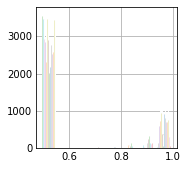

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)
# x = MOD11ds[:,:,1]

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=8, linewidth=0.5, edgecolor="white")

# # ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
# #        ylim=(0, 56), yticks=np.linspace(0, 56, 9))

# plt.show()